In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 8)

def reduce_xticks(p, n: int):
    # FIXME reducing the number of xticks
    # from https://stackoverflow.com/a/38947307/14403987
    for i, label in enumerate(p.get_xticklabels()):
        label.set_visible(True if i % 12 == 0 else False)

DATA_PATH = Path("..", "..", "data")

In [41]:
SALES_PATH = DATA_PATH / "tbl_vendas_mensais.csv"

raw_data = pd.read_csv(SALES_PATH, sep = ";", decimal=",")

# since `dt_sale` is only related to the month, we can drop the rest
raw_data["dt_sale"] = raw_data.dt_sale.str.slice(0, 7) # 2020-11

# # `MachinaMetal` had two instances of 2021-11, therefore they should be grouped

# numeric_columns = raw_data.columns[raw_data.dtypes.isin([np.dtype("int64"), np.dtype("float64")])].difference(["id_sku"])
# data = raw_data.groupby(by = raw_data.columns.difference(numeric_columns).to_list()).aggregate(np.sum).reset_index()
# data["id_sku"] = data["id_sku"].astype(str)

data = raw_data.copy()

### Basic Analysis

In [3]:
SKU_COL = "id_sku"
SKU_NAME = "ds_sku"

In [4]:
data.ds_sku.nunique() # there are 37 named products
data.id_sku.nunique() # there are 39 unique products

39

In [37]:
raw_data.value_counts("dt_sale").head() # 2021-11 has duplicated values

dt_sale
2021-11    72
2023-03    38
2022-09    38
2022-04    38
2022-05    38
dtype: int64

In [5]:
# analysing missing data
data.isnull().sum() # there are 24 (=raw_data.isnull().sum()) missing values in the column "vl_sale_price" before grouping
sku_nan_price = data[data.isnull().sum(axis = 1).astype(bool)].ds_sku.unique() 

# there is no price information on ['Nyc Wave', 'Nyc Sub'], so they will be 
# ignored for the price analysis; 
data[data.ds_sku.isin(sku_nan_price)]

,ds_brand_segment,ds_category,ds_product_line,ds_sku,ds_tecnology,dt_sale,id_sku,qt_sale,vl_sale_price


<Axes: xlabel='ds_sku', ylabel='qt_sale'>

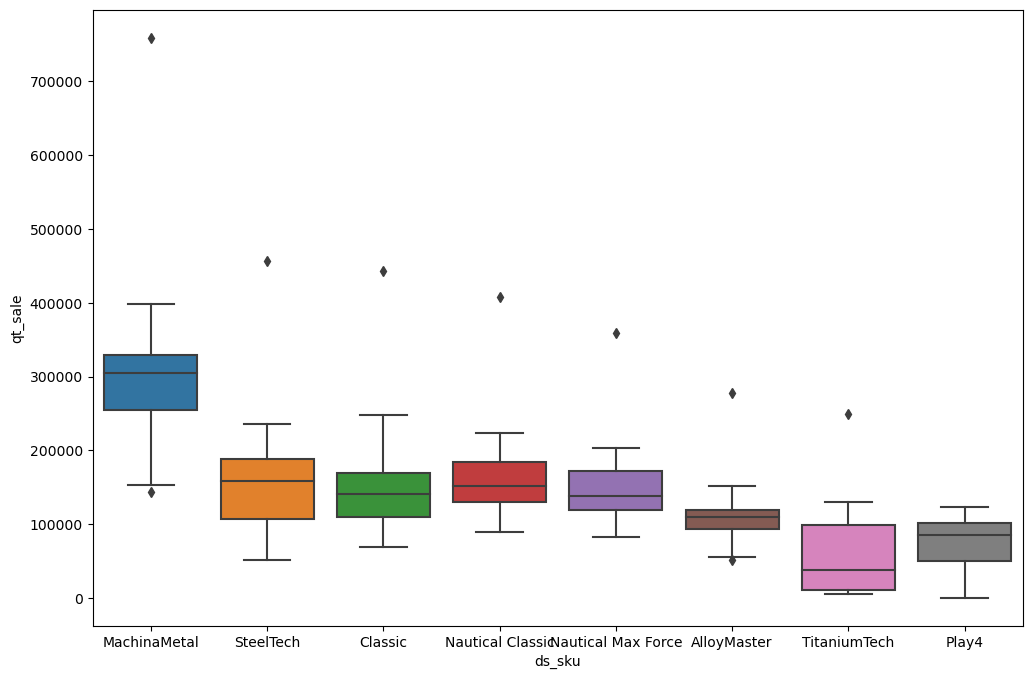

In [282]:
TOP_NPRODUCTS = 8

# identifying the standard deviation per product
gdata = data.groupby(by = [SKU_COL, SKU_NAME, "dt_sale"]).agg({"qt_sale": np.sum})

std_products = gdata.groupby(SKU_NAME).qt_sale.std().sort_values(ascending = False).head(TOP_NPRODUCTS).index.values

gdata.sort_values(by = "qt_sale", ascending = False, inplace = True)

gdata.reset_index(inplace = True)
sns.boxplot(x = SKU_NAME, y = "qt_sale", data = gdata.loc[gdata.ds_sku.isin(std_products)])

# considering the standard deviation, the products with the highest variation are most probably the hardest to forecast

## Exploratory Analysis

In [279]:
TARGET = "qt_sale"

### Are all SKUs sold every month?

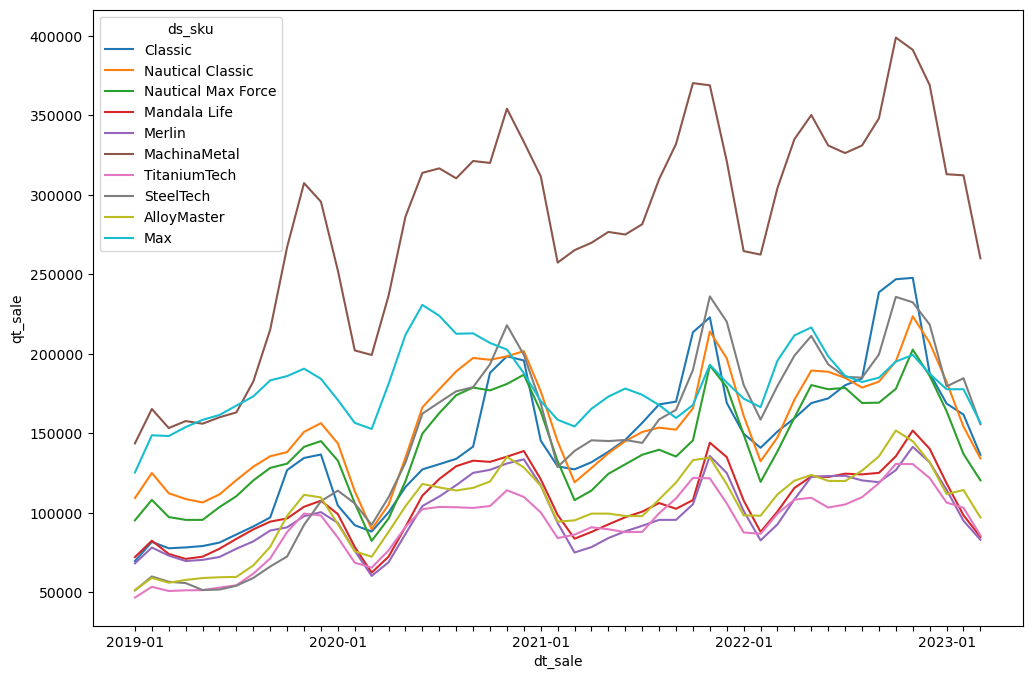

In [42]:
TOP_NPRODUCTS = 10

# gdata = data.groupby(by = [SKU_COL, SKU_NAME, "dt_sale"]).agg({"qt_sale": np.sum})
gdata = data.groupby(by = [SKU_COL, SKU_NAME, "dt_sale"]).agg({"qt_sale": "last"})

top_sales = gdata.groupby(SKU_COL).qt_sale.sum().sort_values(ascending = False).head(TOP_NPRODUCTS).index.values

gdata.reset_index(inplace = True)
p = sns.lineplot(x = "dt_sale", y = "qt_sale", hue = SKU_NAME, data = gdata[gdata[SKU_COL].isin(top_sales)])

reduce_xticks(p, 12)

# it appears that there is a month that had very high sales, which could be an outlier;
# unless this is due to end of the year sales, it should be fixed (or at least not considered for 
# model training)

In [287]:
def fix_sales(name: str, previous: float, current: float, rate: float = 1.5, top_rate: float = 50.):
    """Compares `previous` and `current`, returning `rate * previous` if `current / previous > 1.5`.
    Receives `name` for debugging purposes."""
    # print(name, previous, current, current / previous, sep = "\t")
    if rate < current / previous < top_rate:
        return rate * previous
    # keep the original value, as `Nyc Urban` had one sold item in 2020-11, but 960 in 2021-11
    return current

data.groupby("dt_sale").qt_sale.sum().sort_values(ascending = False).head(10)

# seems to be due to end of the year sales (it is frequently in October, November or December),
# but 2021-11 is seems to be a very hard outlier 5_540_951 / 2_986_284 = 1.85
# therefore it will be normalized to be at most 1.5 times the average sales
# of the previous November per product

previous_sales = data[data.dt_sale == "2020-11"].groupby(SKU_COL).aggregate("qt_sale").sum().to_dict()

data.loc[data.dt_sale == "2021-11", "qt_sale"] = \
    data.loc[data.dt_sale == "2021-11", [SKU_COL, "qt_sale"]].apply(
        lambda row: fix_sales(row[SKU_COL], previous_sales.get(row[SKU_COL], 1.), row["qt_sale"], 1.5), axis = 1
    )

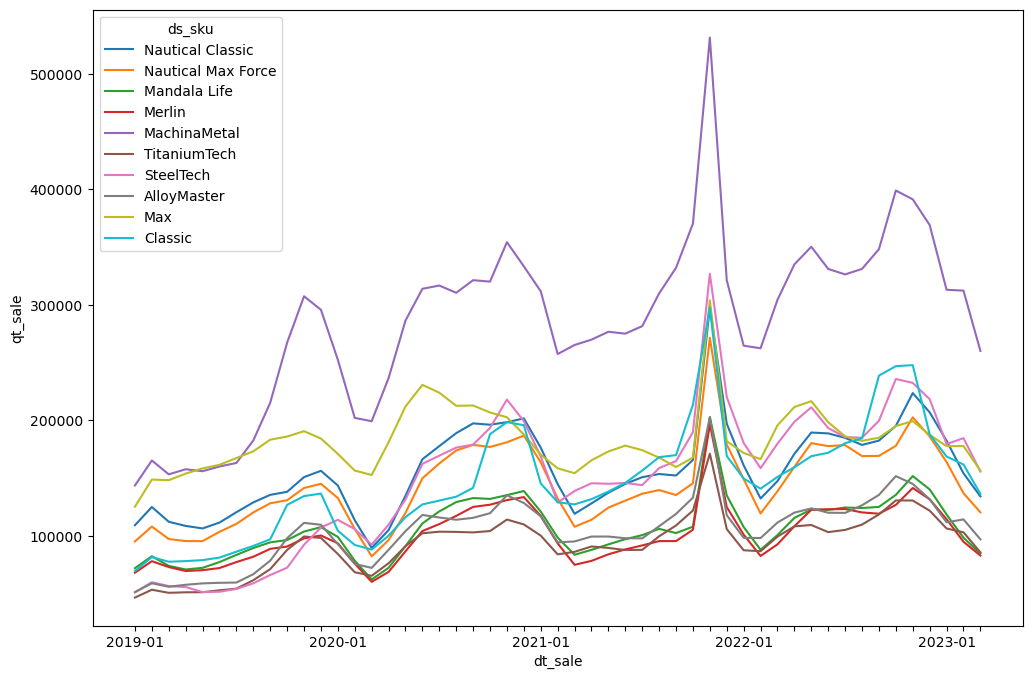

In [288]:
TOP_NPRODUCTS = 10

gdata = data.groupby(by = [SKU_COL, SKU_NAME, "dt_sale"]).agg({"qt_sale": np.sum})

top_sales = gdata.groupby(SKU_COL).qt_sale.sum().sort_values(ascending = False).head(TOP_NPRODUCTS).index.values

gdata.reset_index(inplace = True)
p = sns.lineplot(x = "dt_sale", y = "qt_sale", hue = SKU_NAME, data = gdata[gdata[SKU_COL].isin(top_sales)])

reduce_xticks(p, 12)

# it appears that there is a month that had very high sales, which could be an outlier;
# unless this is due to end of the year sales, it should be fixed (or at least not considered for 
# model training)

### What is the mean and deviation for each product? What is its distribuition?

In [290]:
gdata = data.groupby(by = [SKU_COL, SKU_NAME]).aggregate({"qt_sale": [np.mean, np.std, np.min, np.max]})
gdata[("qt_sale", "mean_over_std")] = gdata[("qt_sale", "mean")] / gdata[("qt_sale", "std")]

gdata.sort_values(by = ("qt_sale", "mean"), ascending = False, inplace = True)
gdata

qt_sale                                    \
                                    mean           std      amin      amax   
id_sku ds_sku                                                                
22     MachinaMetal        284576.980392  75767.219634  143605.0  531342.0   
34     Max                 182201.274510  27930.147006  125262.0  303933.0   
16     Nautical Classic    157160.725490  38145.938216   89553.0  297561.0   
26     SteelTech           149075.019608  60839.710005   51076.0  326919.0   
4      Classic             145924.401961  49446.281631   69531.0  297634.5   
17     Nautical Max Force  143663.882353  35626.034394   82248.0  271473.0   
19     Mandala Life        106304.352941  25919.474474   62223.0  202833.0   
27     AlloyMaster         104530.794118  28691.282724   51283.0  202594.5   
20     Merlin              100610.637255  25182.042812   60166.0  196411.5   
24     TitaniumTech         93004.980392  24541.277682   46541.0  171129.0   
21     Fusion               88118.743243  26268.296906   20529.0  161956.5   
23     SteelEngineer        87922.274510   6543.768306   74101.0  127899.0   
18     Play4                74349.047619  39022.006271     471.0  123308.0   
5      Brand Classic        44761.480392  15357.231850   21138.0   93265.5   
11     Wave                 44688.941176  10732.375359   28278.0   85500.0   
25     AlloyInnovate        38651.294118  10464.035796   18544.0   72951.0   
35     Classic Price        37543.460784   9360.946722   22224.0   54463.5   
12     Athena II            37386.696078   9009.543053   24055.0   71707.5   
13     Hiking               37361.911765   8852.280537   24276.0   71482.5   
1      AeroJet              36176.725490   7750.087600   23661.0   71424.0   
2      FlyQuest             31543.039216   6526.648702   20140.0   60561.0   
6      National Classic     28253.117647   9986.315306   11481.0   57375.0   
36     Hawaii               27208.009804   4323.638239   18454.0   45721.5   
14     Zeus                 22322.000000   5421.838854   14138.0   42891.0   
28     MetalForge           21813.205882   5801.225464   10595.0   40849.5   
38     Comfort              19771.235294   5261.991420   12702.0   42723.0   
3      AirVoyager           17046.078431   4080.805439   10051.0   33915.0   
29     IronCraft            16583.784314   4436.615135    8011.0   31683.0   
37     Top Sport            16315.000000   2499.155297   11226.0   26676.0   
39     Hawaii               11633.950980   3102.687887    7539.0   24979.5   
30     TitaniumTech         10873.264706   2889.023249    5289.0   20266.5   
15     Air                   7418.784314   1777.362420    4691.0   14262.0   
7      Hold Line             6043.500000   3291.187501    1133.0   12449.0   
8      High Bys              5353.460784   3031.619839     928.0   11585.0   
9      High Iris             4454.147059   2425.541128     801.0    9310.0   
32     Nyc Wave              3084.333333   1839.189265    1056.0    5428.0   
33     Nyc Sub               3017.416667   1796.163308    1053.0    5326.0   
10     Cone Stars            2651.921569   1471.937347     443.0    5255.0   
31     Nyc Urban             2155.894737   2148.590000     146.0    5898.0   

                                         
                          mean_over_std  
id_sku ds_sku                            
22     MachinaMetal            3.755938  
34     Max                     6.523463  
16     Nautical Classic        4.119986  
26     SteelTech               2.450291  
4      Classic                 2.951170  
17     Nautical Max Force      4.032553  
19     Mandala Life            4.101331  
27     AlloyMaster             3.643295  
20     Merlin                  3.995333  
24     TitaniumTech            3.789737  
21     Fusion                  3.354566  
23     SteelEngineer          13.436031  
18     Play4                   1.905311  
5      Brand Classic           2.914684  
11     Wave                    4.163938  


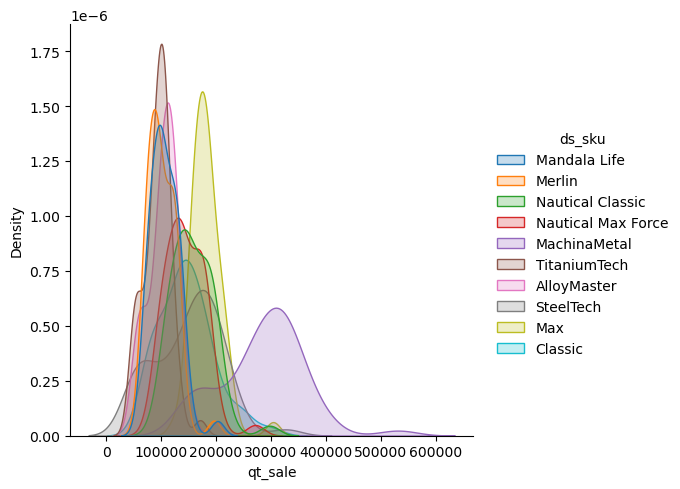

In [292]:
sns.displot(x = "qt_sale", hue = SKU_NAME, kind = "kde", fill = True, data = data[data[SKU_COL].isin(top_sales)])

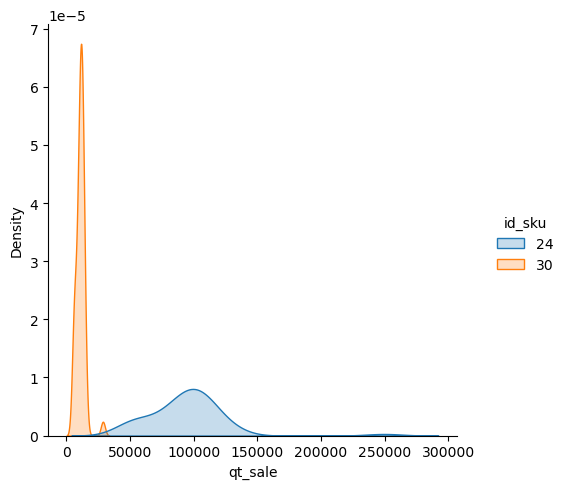

In [16]:
# it is interesting to note that most products do not follow a normal distribution e.g. `TitaniumTech`, which
# makes it very hard to use a linear model to predict sales; but using a tree-based model restricts the predictions
# to values in the current domain (tree-based models are not extrapolative), which then would require to use another
# method to predict trend. For the sake of simplicity, it will be assumed that the distribution is normal for now.
# CORRECTION: same name, but two different products!

sns.displot(x = "qt_sale", hue = SKU_COL, kind = "kde", fill = True, data = data[data[SKU_NAME] == "TitaniumTech"])

### How does each Product Line, Category and SKU behave?

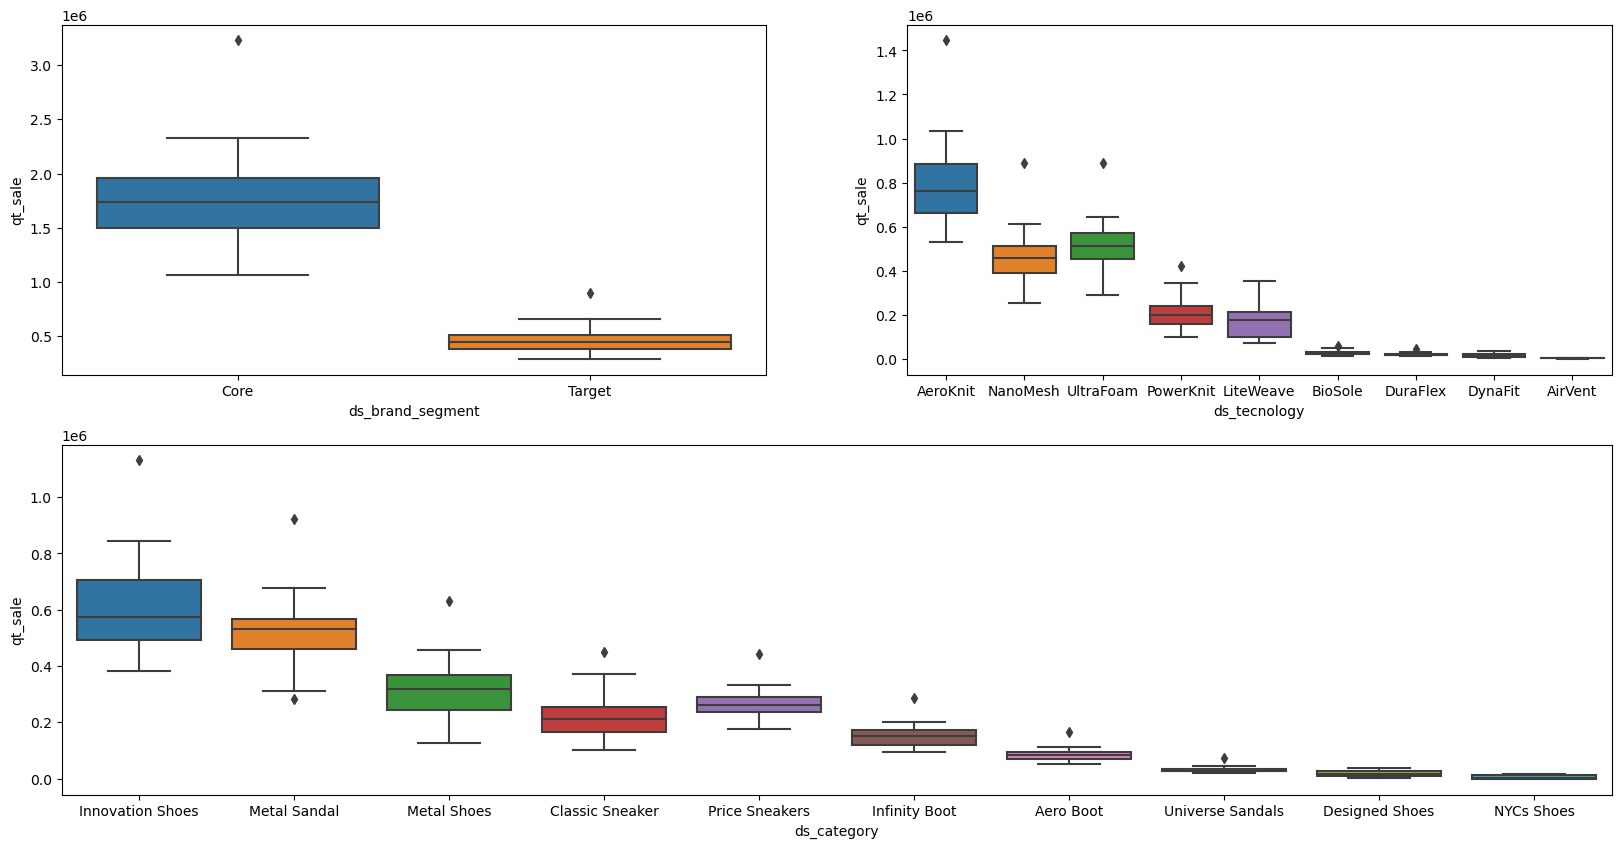

In [237]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
for i, col in enumerate(["ds_brand_segment", "ds_tecnology", "ds_category"]):
    ax = axs[i // 2, i % 2] if i < 2 else fig.add_subplot(212)
    gdata = data.groupby(by = [col, "dt_sale"]).agg({"qt_sale": np.sum}).sort_values(by = "qt_sale", ascending = False)
    sns.boxplot(x = col, y = "qt_sale", data = gdata.reset_index(), ax = ax)
axs[1, 0].remove()
axs[1, 1].remove()

### Does the price vary with time? What is the distribution of price per Brand, Category and SKU?

<Axes: xlabel='ds_sku', ylabel='mean_price'>

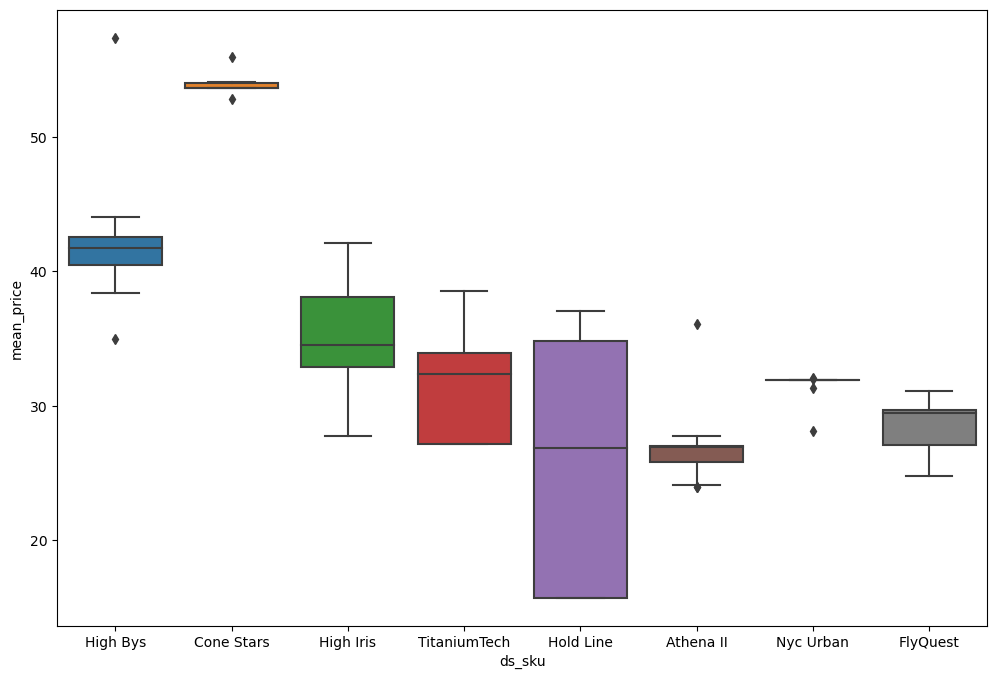

In [299]:
TOP_NPRODUCTS = 8

# aggregating data by product to calculate mean prices
gdata = data.groupby(by = [SKU_COL, SKU_NAME, "dt_sale"]).agg({"qt_sale": np.sum, "vl_sale_price": np.sum}).dropna(how = "any")

gdata["mean_price"] = gdata.vl_sale_price / gdata.qt_sale

gdata.sort_values(by = "mean_price", ascending = False, inplace = True)

expensive_products = gdata.groupby(SKU_COL).mean_price.mean().sort_values(ascending = False).head(TOP_NPRODUCTS).index.values

gdata.reset_index(inplace = True)
gdata.sort_values(by = "mean_price", ascending = False, inplace = True)
sns.boxplot(x = SKU_NAME, y = "mean_price", data = gdata.loc[gdata[SKU_COL].isin(expensive_products)])

# considering the average price, it could be expected that products with a high standard devation
# are more dependant on price to be sold e.g. `Hold Line`

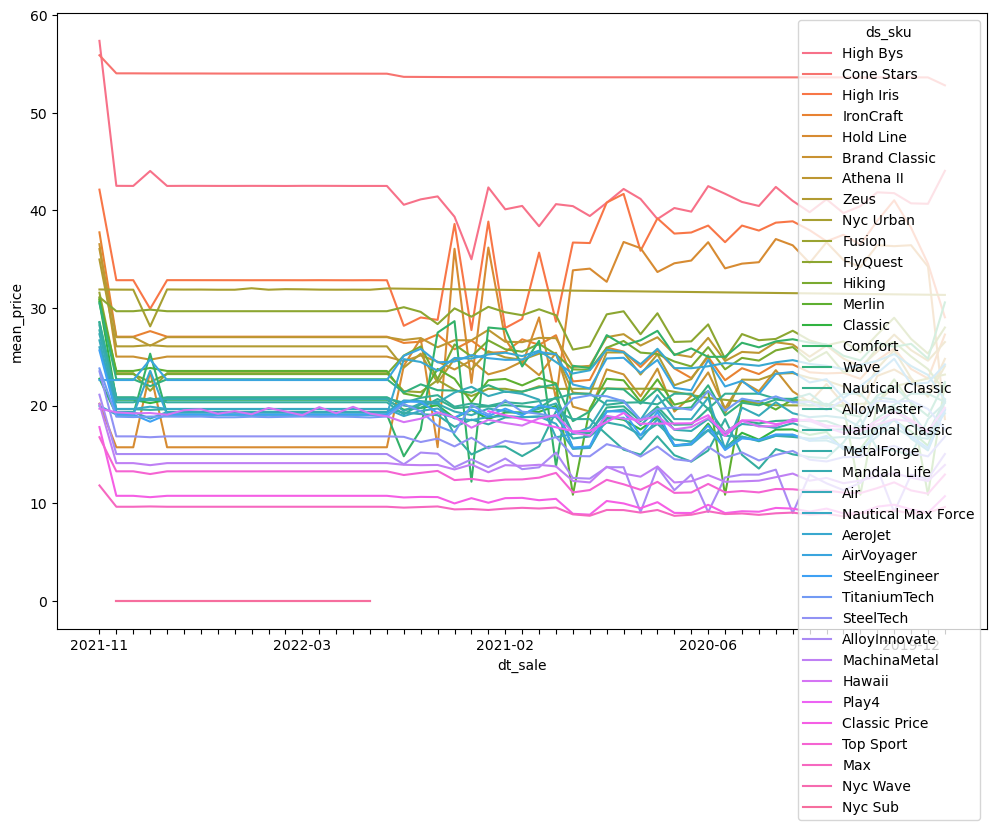

In [263]:
p = sns.lineplot(x = "dt_sale", y = "mean_price", hue = SKU_COL, data = gdata)
reduce_xticks(p, 12)

In [300]:
corr_per_product = data.groupby(by = [SKU_COL, SKU_NAME]).apply(lambda x: x["qt_sale"].corr(x["vl_sale_price"])).sort_values(ascending = False)
corr_per_product

# products have a high correlation between `sales` and how much money was received for them, but that doesn't make it clear
# if reducing prices boosts sales. What is clear is that the prices varies from month to month, indicating that there might
# be a relation there.

id_sku  ds_sku            
31      Nyc Urban             0.999960
10      Cone Stars            0.999876
18      Play4                 0.998085
9       High Iris             0.994735
8       High Bys              0.990366
39      Hawaii                0.976779
11      Wave                  0.975522
12      Athena II             0.975217
14      Zeus                  0.974481
3       AirVoyager            0.973912
26      SteelTech             0.973113
19      Mandala Life          0.971190
17      Nautical Max Force    0.971000
36      Hawaii                0.969942
16      Nautical Classic      0.966969
29      IronCraft             0.966405
5       Brand Classic         0.965683
7       Hold Line             0.964889
20      Merlin                0.963530
34      Max                   0.962649
15      Air                   0.962030
4       Classic               0.962009
21      Fusion                0.961758
2       FlyQuest              0.961127
22      MachinaMetal          0.95841

### How does each category of products behave?

Marcio: the category defines how the product behaves over time

In [6]:
data.head()

,ds_brand_segment,ds_category,ds_product_line,ds_sku,ds_tecnology,dt_sale,id_sku,qt_sale,vl_sale_price
0,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-01,10,3742,200646.5232
1,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-02,10,4156,222872.3922
2,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-03,10,3748,200976.1040
3,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-04,10,3398,182246.8222
4,Core,Designed Shoes,Shoes,Cone Stars,AirVent,2019-05,10,3628,194581.4786


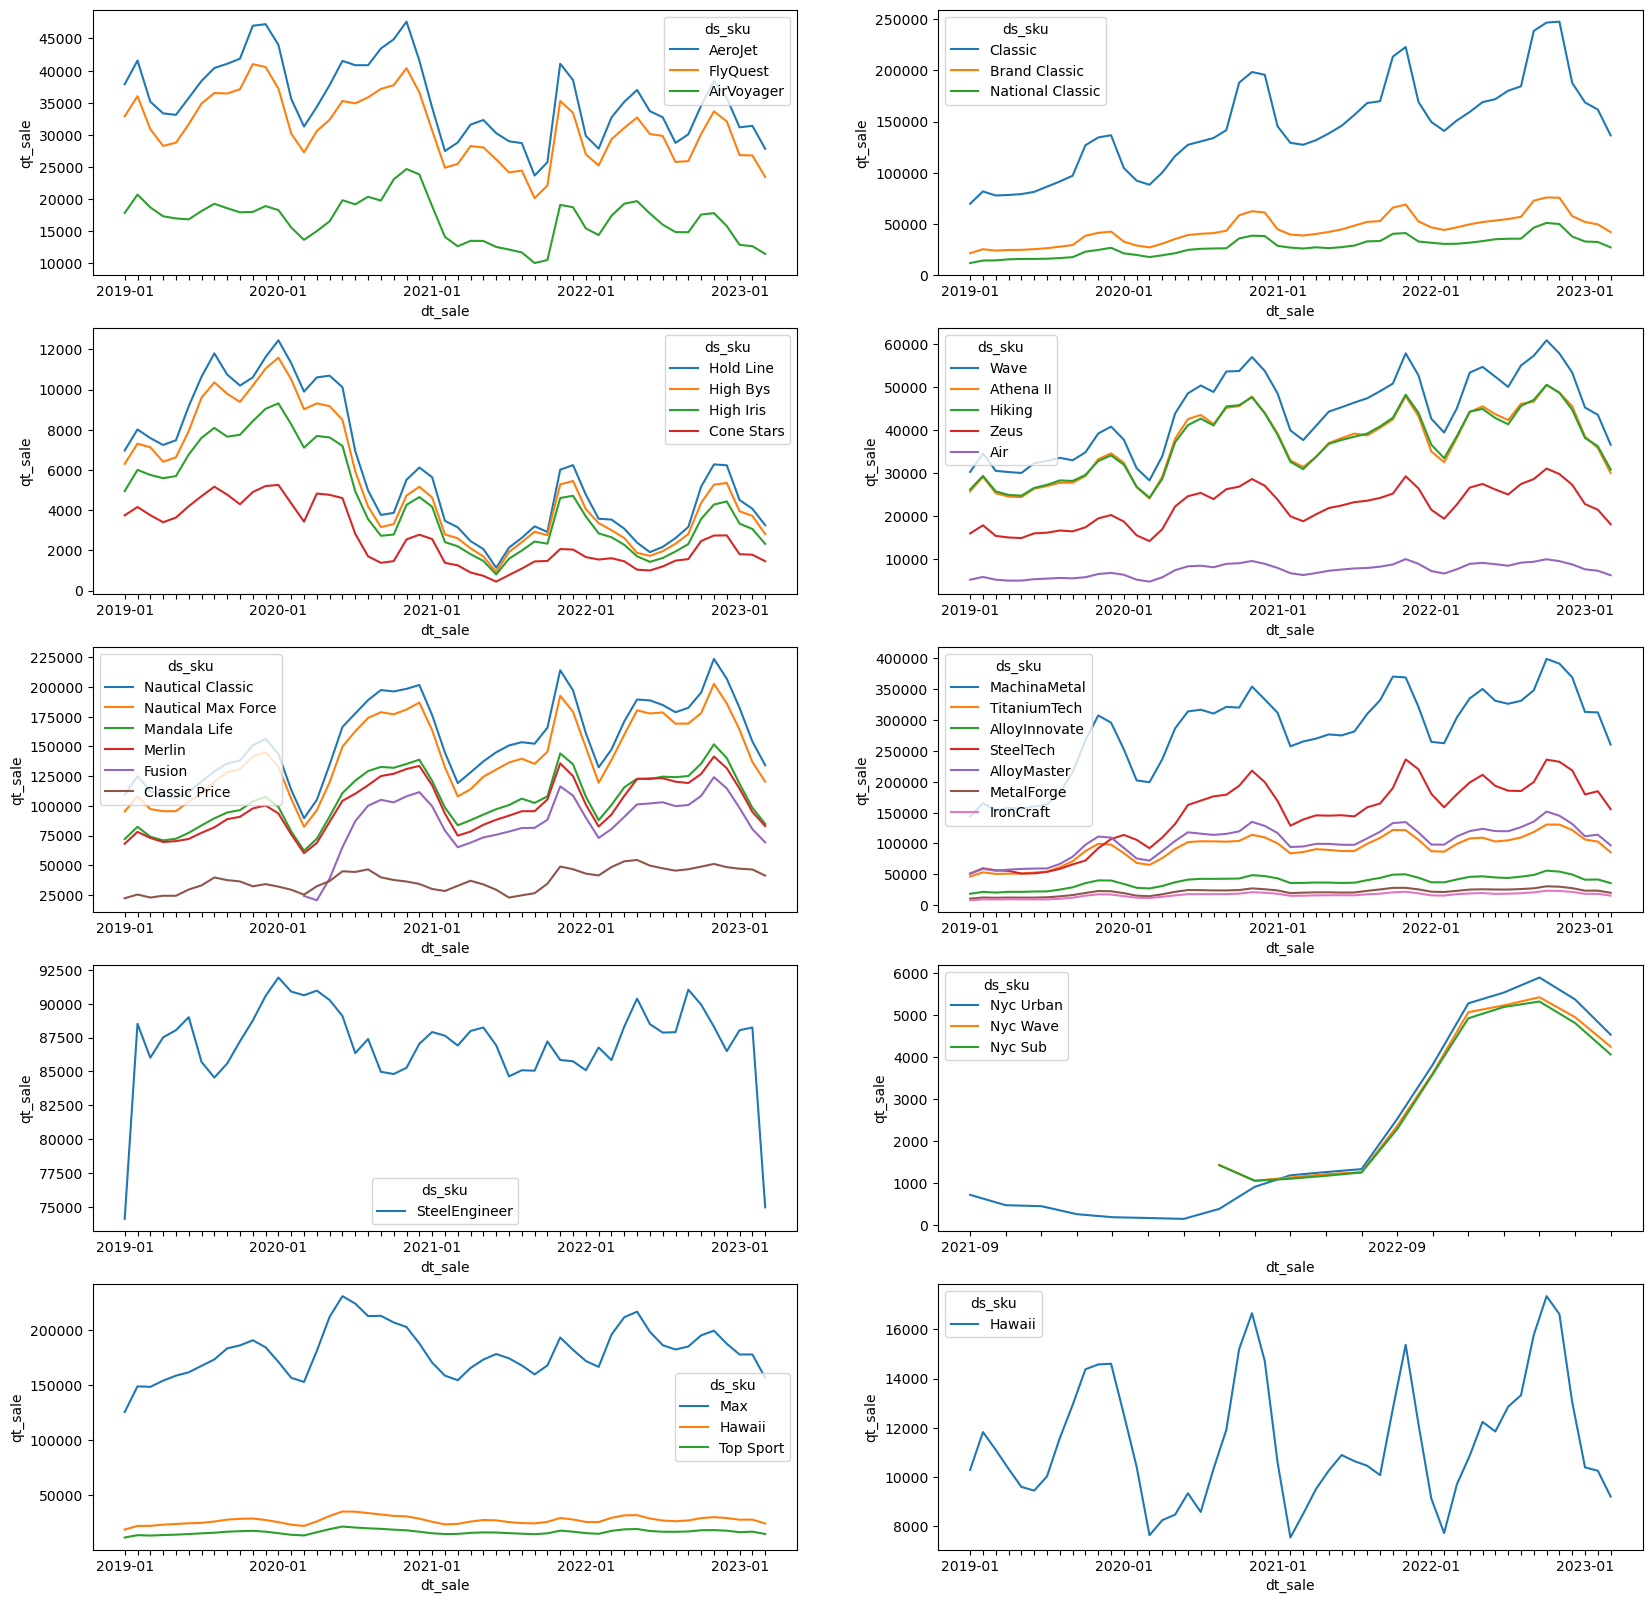

In [45]:
expected_groups = (
    (1, 2, 3),
    (4, 5, 6),
    (7, 8, 9, 10),
    (11, 12, 13, 14, 15),
    (16, 17, 19, 20, 21, 35),
    (22, *range(24, 30 + 1)),
    (23,),
    (31, 32, 33),
    (34, 36, 37),
    (38, 39),
)

fig, axs = plt.subplots(5, 2, figsize = (20, 20))
for i, group in enumerate(expected_groups):
    ax = axs[i // 2, i % 2]
    gdata = data[data[SKU_COL].isin(group)].groupby(by = [SKU_COL, SKU_NAME, "dt_sale"]).agg({"qt_sale": "last"}).reset_index()
    sns.lineplot(x = "dt_sale", y = "qt_sale", hue = SKU_NAME, data = gdata, ax = ax)
    reduce_xticks(ax, 12)